In [143]:
import pandas as pd
import numpy as np
import seaborn as sns

# data cleaning
df = pd.read_csv('data/AirQualityUCI.csv', sep=';')
df.insert(0, 'Timestamp', pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H.%M.%S'))
df = df.drop(['Unnamed: 15', 'Unnamed: 16', 'Date', 'Time'], axis=1)
for col in df.columns.drop('Timestamp'):
    df[col] = df[col].map(lambda x: float(str(x).replace(',', '.')))
df = df.replace(-200, np.nan)
df = df.loc[~pd.isnull(df['Timestamp']), :]


In [147]:
# predict NMHC at t using all other features at t
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

features = ['CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)','NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)','T', 'RH', 'AH']
predict = 'NMHC(GT)'

# drop nan values from dataset, scale data and split into X,y 
df = df.drop('Timestamp',axis=1)
# scaler = MinMaxScaler()
# df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
original = df.copy()
df.dropna(inplace=True)


# scaled_data = pd.DataFrame(scaler.fit_transform(df[features]), columns=features, index=df.index)
scaled_data = df[features]
X = scaled_data
y = df[predict]


# split into training data and test data
train_prop = 0.7
rs = np.random.RandomState(345)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rs)

In [148]:
# fit models
m_linearReg = LinearRegression().fit(X_train, y_train)
m_lasso = Lasso().fit(X_train, y_train)
m_ridge = Ridge().fit(X_train, y_train)

# evaluate models
ypred_train_linearReg = m_linearReg.predict(X_train)
ypred_train_lasso = m_lasso.predict(X_train)
ypred_train_ridge = m_ridge.predict(X_train)

ypred_test_linearReg = m_linearReg.predict(X_test)
ypred_test_lasso = m_lasso.predict(X_test)
ypred_test_ridge = m_ridge.predict(X_test)



loss_data = [
    ['linear regression',
     mean_squared_error(y_train, ypred_train_linearReg),
     mean_squared_error(y_test, ypred_test_linearReg),
     mean_absolute_error(y_train, ypred_train_linearReg),
     mean_absolute_error(y_test, ypred_test_linearReg)
    ],
    ['lasso',
     mean_squared_error(y_train, ypred_train_lasso),
     mean_squared_error(y_test, ypred_test_lasso),
     mean_absolute_error(y_train, ypred_train_lasso),
     mean_absolute_error(y_test, ypred_test_lasso)
    ],
    ['ridge',
     mean_squared_error(y_train, ypred_train_ridge),
     mean_squared_error(y_test, ypred_test_ridge),
     mean_absolute_error(y_train, ypred_train_ridge),
     mean_absolute_error(y_test, ypred_test_ridge)
    ]
]

# create a pandas dataframe and feed it the array and naming the columns
cols = ['Model', 'train MSE', 'test MSE', 'train MAE', 'test MAE']
loss_df = pd.DataFrame(loss_data, columns=cols)
loss_df

c:\Users\Susan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.011e+03, tolerance: 2.832e+03
  model = cd_fast.enet_coordinate_descent(


,Model,train MSE,test MSE,train MAE,test MAE
0,linear regression,5938.872115,6823.200800,52.548271,55.395230
1,lasso,5982.380628,6791.805729,52.360365,55.031762
2,ridge,5946.540889,6827.715157,52.427229,55.296321


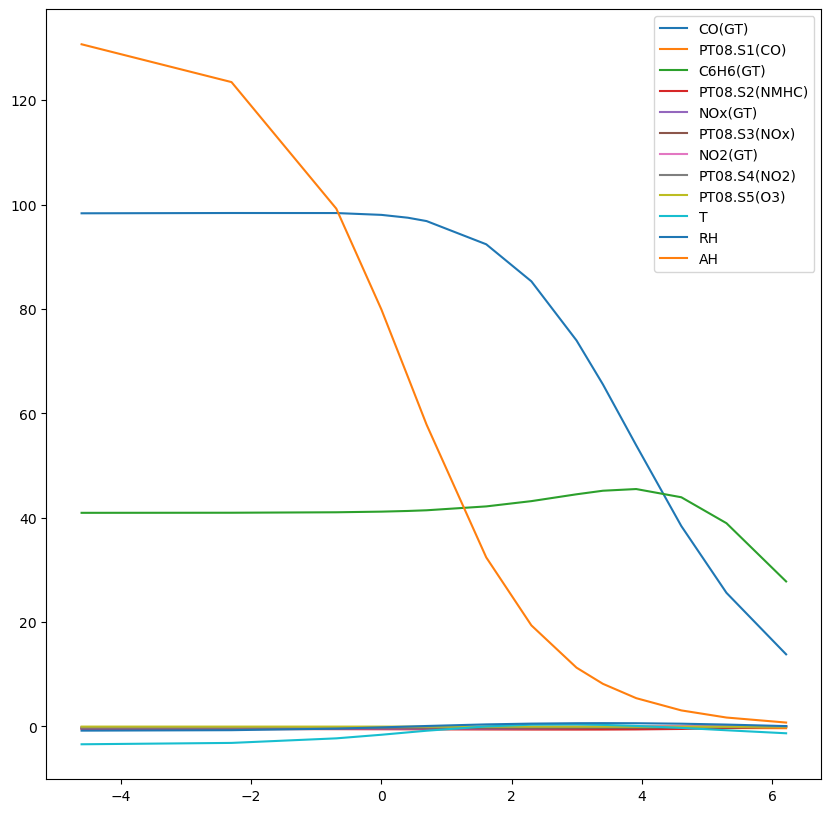

In [149]:
# hyperparam search for lasso
import matplotlib.pyplot as plt

alphas = [0.01, 0.1, 0.5, 1, 1.5, 2, 5, 10, 20, 30, 50, 100, 200, 500]
values = []

for a in alphas:
    reg = Ridge(alpha=a)
    reg.fit(X, y)
    values.append(reg.coef_)

plt.figure(figsize=(10,10))
# colors = ['red', 'brown', 'green', 'blue', 'orange', 'pink', 'purple', 'grey']
for i in range(len(features)):
    plt.plot(np.log(alphas), [v[i] for v in values], label=f'{features[i]}')

plt.legend()
plt.show()

In [150]:
lambdas = np.arange(0, 50.1, step= 5)
n = scaled_data.shape[0]
N = lambdas.shape[0]
CV_score = np.zeros(N)
curIdx = 0
Y = df[predict].to_numpy()

scaled_data = np.array(scaled_data)
for L in lambdas:
    sq_errs = 0.
    for i in range(n):
        x_i = scaled_data[i]
        x_removed_i = np.delete(scaled_data, i, axis=0)
        y_i = Y[i]
        y_removed_i = np.delete(Y, i, axis=0)

        mod = Ridge(alpha=L).fit(x_removed_i, y_removed_i)
        pred = (mod.predict(x_i.reshape(1, -1)) - y_i) ** 2
        sq_errs += pred[0]
    
    CV_score[curIdx] = sq_errs / n
    curIdx += 1

min_idx = np.argmin(CV_score)
plt.plot(lambdas, CV_score)
plt.xlabel(r"$\lambda$")
plt.ylabel("LOOCV Score (Ridge)")
plt.axvline(x=lambdas[min_idx], color="red")
plt.annotate(f"$\lambda = {lambdas[min_idx]}$", xy=(25,1800))
plt.show()

# Why is this concave???
# Seems like basic linear regression is the best way

KeyboardInterrupt: 

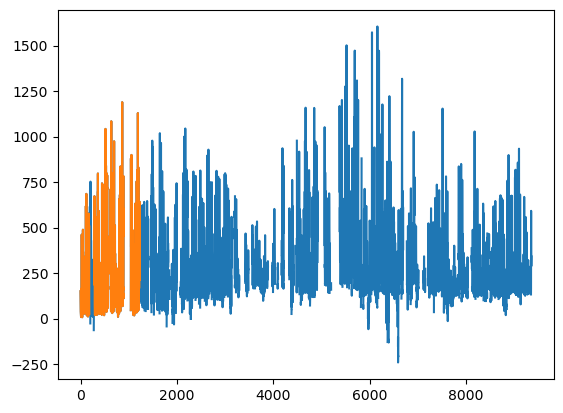

In [ ]:
# use a regression model to predict all the NMHC
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

df = pd.read_csv('data/AirQualityUCI.csv', sep=';')
df.insert(0, 'Timestamp', pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H.%M.%S'))
df = df.drop(['Unnamed: 15', 'Unnamed: 16', 'Date', 'Time'], axis=1)
for col in df.columns.drop('Timestamp'):
    df[col] = df[col].map(lambda x: float(str(x).replace(',', '.')))
df = df.replace(-200, np.nan)
df = df.loc[~pd.isnull(df['Timestamp']), :]

features = ['CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)','NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)','T', 'RH', 'AH']
predict = 'NMHC(GT)'

# we train on all data where predict and features are not nan
df_nn = df.dropna()
X = df_nn[features]
y = df_nn[predict]

model = LinearRegression()
model.fit(X=X, y=y)

# we apply the model to data where features are not nan
X = df[features]
X_nn = X.dropna()
predictions = model.predict(X_nn)

# write to df
nan_inds = np.where(df[predict].isnull())[0]
predictions = pd.DataFrame(predictions, index=X_nn.index)

imputed = df.copy()

for i in nan_inds:
    if i in predictions.index:
        imputed.loc[i, predict] = predictions.loc[i,0]

plt.plot(imputed[predict])
plt.plot(df[predict])

# write to file
imputed.to_csv('output_data/NMHC(GT)_imputed')